In [102]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [214]:
class OptimizerAgent(nn.Module):
    def __init__(self, hidden_dim, n_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(1, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, self.h = self.gru(x, self.h.detach())
        out = self.fc(out)
        return out
    
    def reset(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        self.h = hidden

In [285]:
def generate_problem(n):
    A = torch.randn(n,n)
    A = A.T@A
    b = torch.randn(n)
    b = A.T@b
    x0 = torch.randn(n)
    return A,b,x0

In [279]:
def run_epoch(agent, opt, n_iter=100, unroll=20):
    agent.reset(n)
    A, b, x0 = generate_problem(n)

    x = x0.clone()
    loss = torch.tensor(0.)

    for i in range(n_iter+2):
        g = A@x-b
        loss += g@g

        d = agent(g.data.unsqueeze(-1).unsqueeze(-1))
        d = d.squeeze().squeeze()
        
        x = x + d

        if i>1 and i % unroll == 1:
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss = torch.tensor(0.)
            x = x.detach()

    g = g.detach().numpy()
    return g@g

In [313]:
def minimize(update, A, b, x0, n_iter):
    x = x0.clone()
    x_prev = x0.clone()
    g_prev = torch.zeros_like(x0)
    g_normsq_list = []

    for _ in range(n_iter):
        g = A@x-b
        g_normsq_list += [g@g]

        d = update(g, g_prev, x, x_prev)
        
        g_prev = g.clone()
        x_prev = x.clone()
        
        x = x + d

    return g_normsq_list


def run_agent(A, b, x0, n_iter):
    agent.reset(x0.shape[0])

    def update(g, g_prev, x, x_prev):
        with torch.no_grad():
            d = agent(g.unsqueeze(-1).unsqueeze(-1))
            return d.squeeze().squeeze()

    return minimize(update, A, b, x0, n_iter)


def run_GD(A, b, x0, n_iter):
    L = np.linalg.eigvals(A).max()
    alpha = 1/L
    def update(g, g_prev, x, x_prev):
        return -alpha*g

    return minimize(update, A, b, x0, n_iter)    


def run_BB(A, b, x0, n_iter):
    def update(g, g_prev, x, x_prev):
        if torch.norm(x-x_prev) < 1e-8:
            return -.05*g
        s = x-x_prev
        y = g-g_prev
        alpha = (s@y)/(y@y)
        return -alpha*g

    return minimize(update, A, b, x0, n_iter)   


def run_NAG(A, b, x0, n_iter):
    L = np.linalg.eigvals(A).max()
    alpha = 1/L
    kappa = np.linalg.cond(A)
    beta = 1 - 2/(np.sqrt(kappa) + 1)
    print(beta)
    def update(g0, g_prev, x, x_prev):
        y = x + beta*(x-x_prev)
        g = A@y-b
        return y-x - alpha*g

    return minimize(update, A, b, x0, n_iter)   


In [281]:
def validate(agent, n_validations, n_iter):
    agent.eval()
    g_normsq_arr = np.zeros(n_validations)
    with torch.no_grad():
        for i in range(n_validations):
            A, b, x0 = generate_problem(n)
            agent_g_normsq_list = run_agent(A, b, x0, n_iter)
            g_normsq_arr[i] = agent_g_normsq_list[-1]
    avg_g_norm = np.sqrt(g_normsq_arr).mean()
    return avg_g_norm, agent.state_dict()

In [286]:
n = 10
agent = OptimizerAgent(hidden_dim=20, n_layers=2)
opt = torch.optim.Adam(agent.parameters(), .003)

n_epochs = 50
n_validations = 10
n_iter = 100
epoch_results = []
for _ in range(n_epochs):
    run_epoch(agent, opt)
    epoch_results += [validate(agent, n_validations, n_iter)]
    print(epoch_results[-1][0])


8.113821263641565
10.902127687982174
12.296734448187284
8.28369411592902
6.344408851056071
6.610923554973364
1.7591513328296362
1.6466340885176671
1.4269019308641264
0.579558967121535
0.6192565374879717
0.15136432057372612
0.18148343804150346
0.06805341393513799
0.07702262221204274
0.0740095165373228
0.07628725528921655
0.05812628563623732
0.03985530031363389
0.03914507727551244
0.042061340684060596
0.032251947360389645
0.04975406676826841
0.04873837345418029
0.0516135847820963
0.058795080876707526
0.044098334020360695
0.03594591032450706
0.04122363378880783
0.022269483206611155
0.04649326406900391
0.050801829490525786
0.04894337675204258
0.04144696741507786
0.03848603273688086
0.05081287393713518
0.032807952073392176
0.053088286773617
0.04772793622902884
0.04391836268978893
0.05390609211846771
0.09000723742196323
0.048976846656607606
0.08766034658937635
0.04997945348756701
0.04748691588716825
0.057073203355113955
0.03035111088611465
0.10168924497543999
0.07556488433759084


In [287]:
best_params = min(epoch_results, key=lambda t: t[0])[1]
agent.load_state_dict(best_params)
agent.eval()

OptimizerAgent(
  (gru): GRU(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

0.8815150287603257


Text(0, 0.5, 'log of gradient norm')

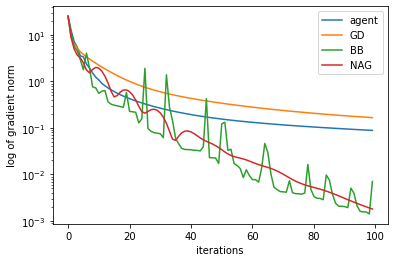

In [324]:
n_iter = 100
A, b, x0 = generate_problem(n)

names = ['agent', 'GD', 'BB', 'NAG']
run_funcs = [run_agent, run_GD, run_BB, run_NAG]

for name, run in zip(names, run_funcs):
    g_normsq_list = run(A, b, x0, n_iter)
    plt.plot(np.arange(n_iter), np.sqrt(np.array(g_normsq_list)))

plt.yscale('log')
plt.legend(names)
plt.xlabel('iterations')
plt.ylabel('log of gradient norm')

Text(0, 0.5, 'log of gradient norm')

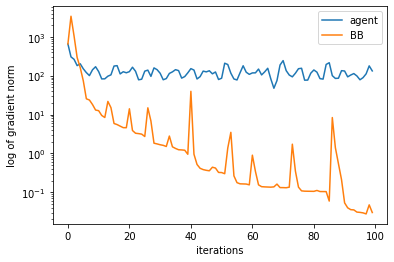

In [277]:
n_iter = 100
grad_f, x0 = generate_problem(50)

names = ['agent', 'BB']
run_funcs = [run_agent, run_BB]

for name, run in zip(names, run_funcs):
    g_normsq_list = run(grad_f, x0, n_iter)
    plt.plot(np.arange(n_iter), np.sqrt(np.array(g_normsq_list)))

plt.yscale('log')
plt.legend(names)
plt.xlabel('iterations')
plt.ylabel('log of gradient norm')

In [267]:
x0.shape[0]

20